# Denoising filter testing
## required libaries

In [1]:
import os, time, cv2
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from scipy.ndimage import median_filter
from skimage.draw import line as skidline
import functions as f

home_dir = os.path.abspath("")

## load file

In [2]:
#filepath_noisy = filedialog.askopenfilename(title='Please select the image',filetypes=[("Tiff images", "*.tif;*.tiff")])
tiff_file  = home_dir + os.sep + '84d tiff.tif'
CT = f.CTPreprocessor(tiff_file)

Dimensions: z = 1510, h = 1905, w = 1908 [px]


## Show the loaded images

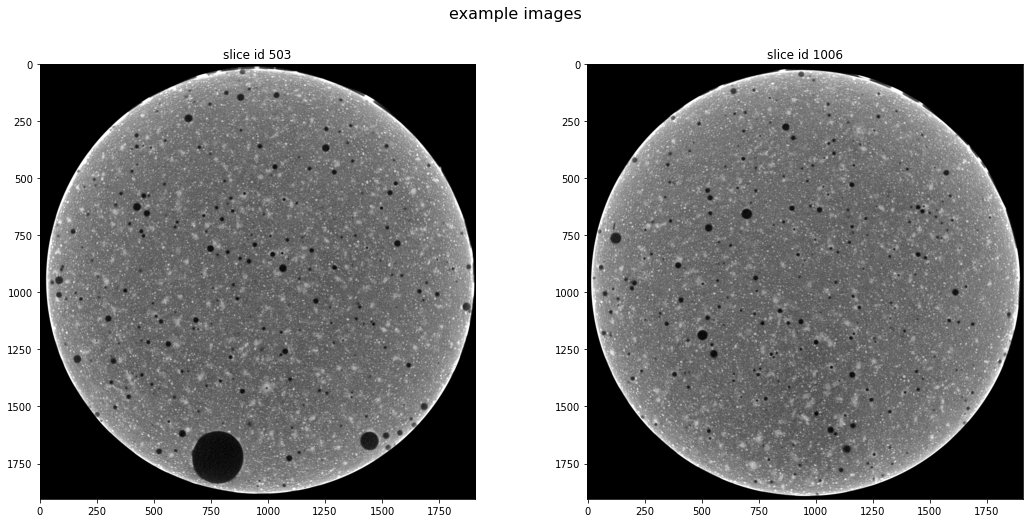

In [3]:
CT.show_example_slices()

## process the main circle, its center point and the inner pores

In [4]:
slice	= CT.select_slice(int(CT.z/3*2))

CT.identify_main_circle(threshold=20)
CT.get_main_circle()

CT.identify_pores(threshold=70)
CT.remove_pores()

found the center point at (954, 956). The circle has a maximum radius of 949 px.


## show images

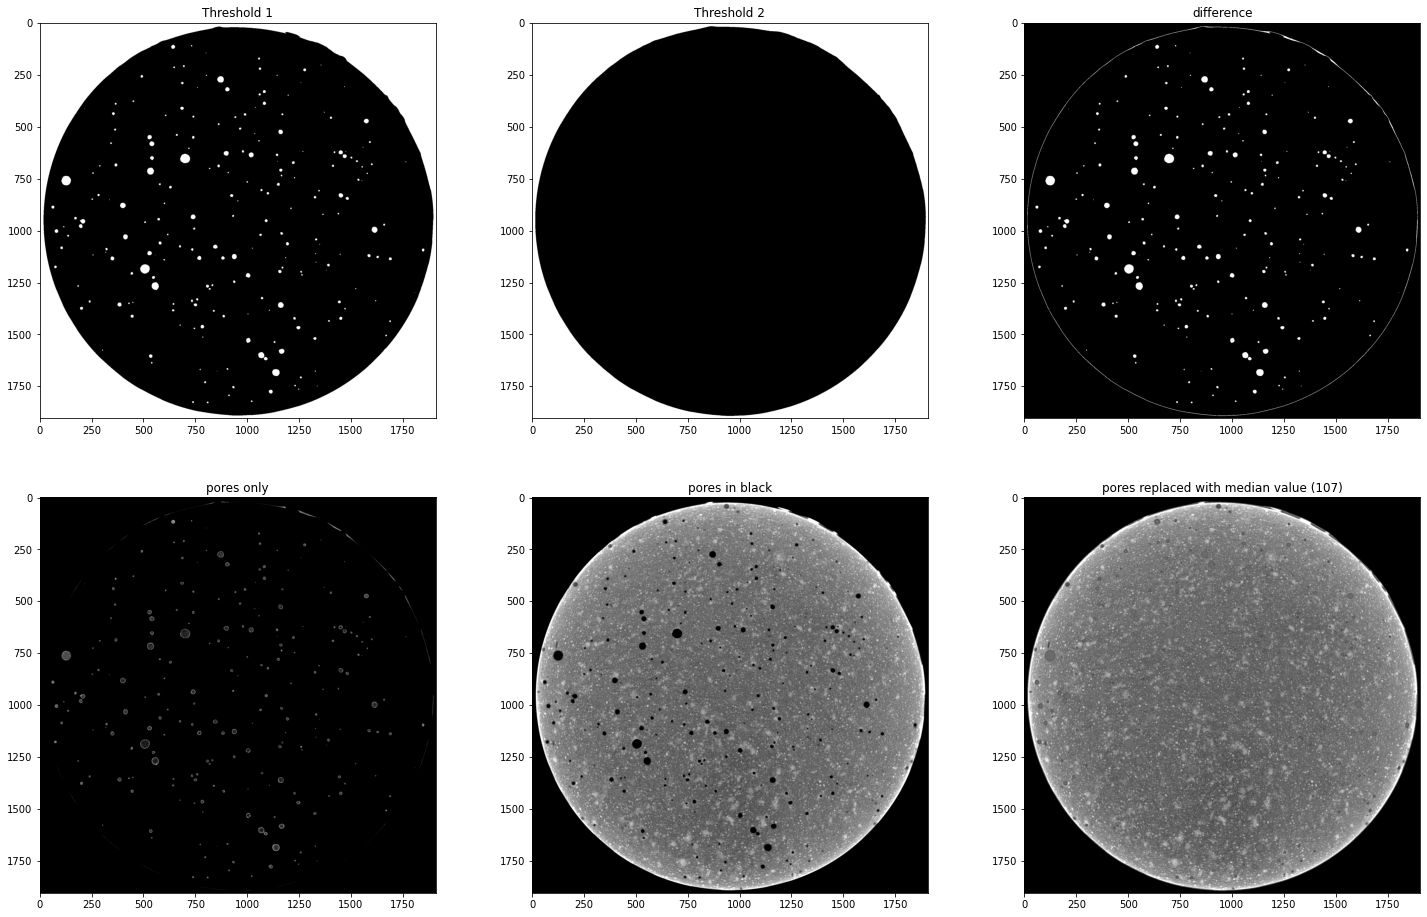

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(25, 16))
#fig.suptitle('raw images', fontsize=16)

ax[0, 0].imshow( CT.pore_thresh, cmap='gray' )
ax[0, 0].set_title( "Threshold 1" )

ax[0, 1].imshow( CT.main_circle, cmap='gray')
ax[0, 1].set_title( "Threshold 2" )

ax[0, 2].imshow( CT.inner_pores*np.median( CT.slice ), cmap='gray' )
ax[0, 2].set_title( "difference" )

ax[1, 0].imshow( CT.slice * CT.inner_pores, cmap='gray' )
ax[1, 0].set_title( "pores only" )

ax[1, 1].imshow( CT.slice * np.logical_not(CT.inner_pores), cmap='gray' )
ax[1, 1].set_title( "pores in black" )

ax[1, 2].imshow( CT.removed_pores , cmap='gray' )
ax[1, 2].set_title( "pores replaced with median value ({:.0f})".format(np.median( CT.slice )) )

plt.show()
print()

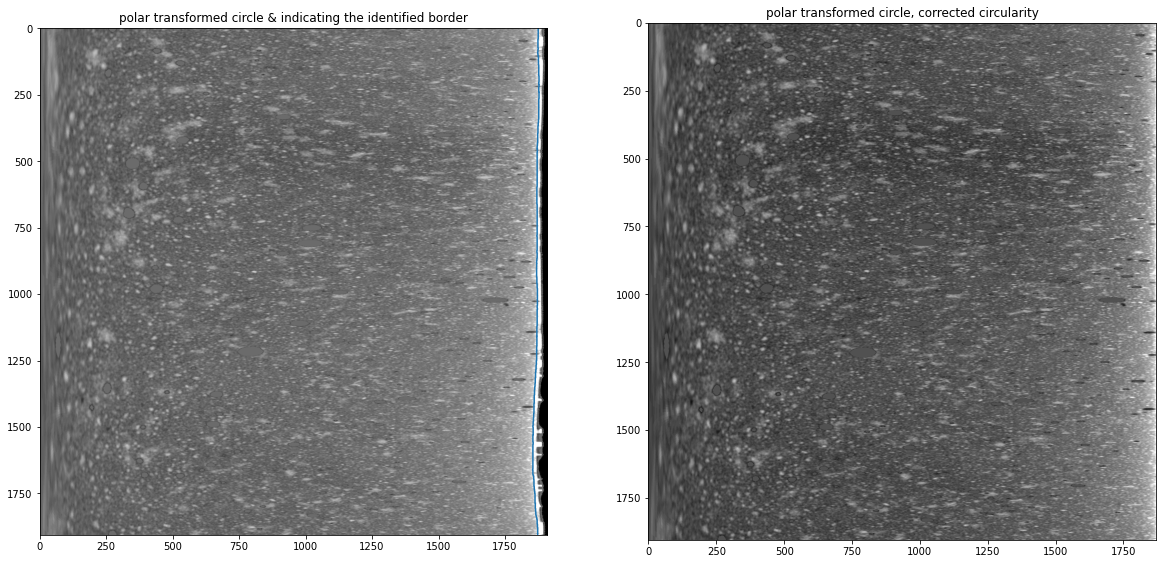

[[102. 102. 106. ...   0.   0.   0.]
 [102. 102. 106. ...   0.   0.   0.]
 [102. 102. 106. ...   0.   0.   0.]
 ...
 [102. 102. 106. ...   0.   0.   0.]
 [102. 102. 106. ...   0.   0.   0.]
 [102. 102. 106. ...   0.   0.   0.]]
[[[101]
  [102]
  [106]
  ...
  [255]
  [255]
  [255]]

 [[101]
  [102]
  [106]
  ...
  [236]
  [254]
  [255]]

 [[101]
  [102]
  [106]
  ...
  [252]
  [254]
  [255]]

 ...

 [[102]
  [102]
  [106]
  ...
  [255]
  [255]
  [255]]

 [[102]
  [102]
  [106]
  ...
  [255]
  [255]
  [255]]

 [[102]
  [102]
  [106]
  ...
  [255]
  [255]
  [255]]]


In [6]:
polar_image = CT.circle_to_polar()

border_position, border_deviation = CT.get_border_deviation(polar_image, show_graph = False)
polar_image_corr = CT.correct_circularity( show_result = True )

print(polar_image.shape)
print(polar_image_corr.shape)

In [7]:
polar_background, polar_background_fit, background_offset = CT.get_polar_background(polar_image_corr)

Exception: No polar image found. Check call variable polar_image or call self.circle_to_polar() first!

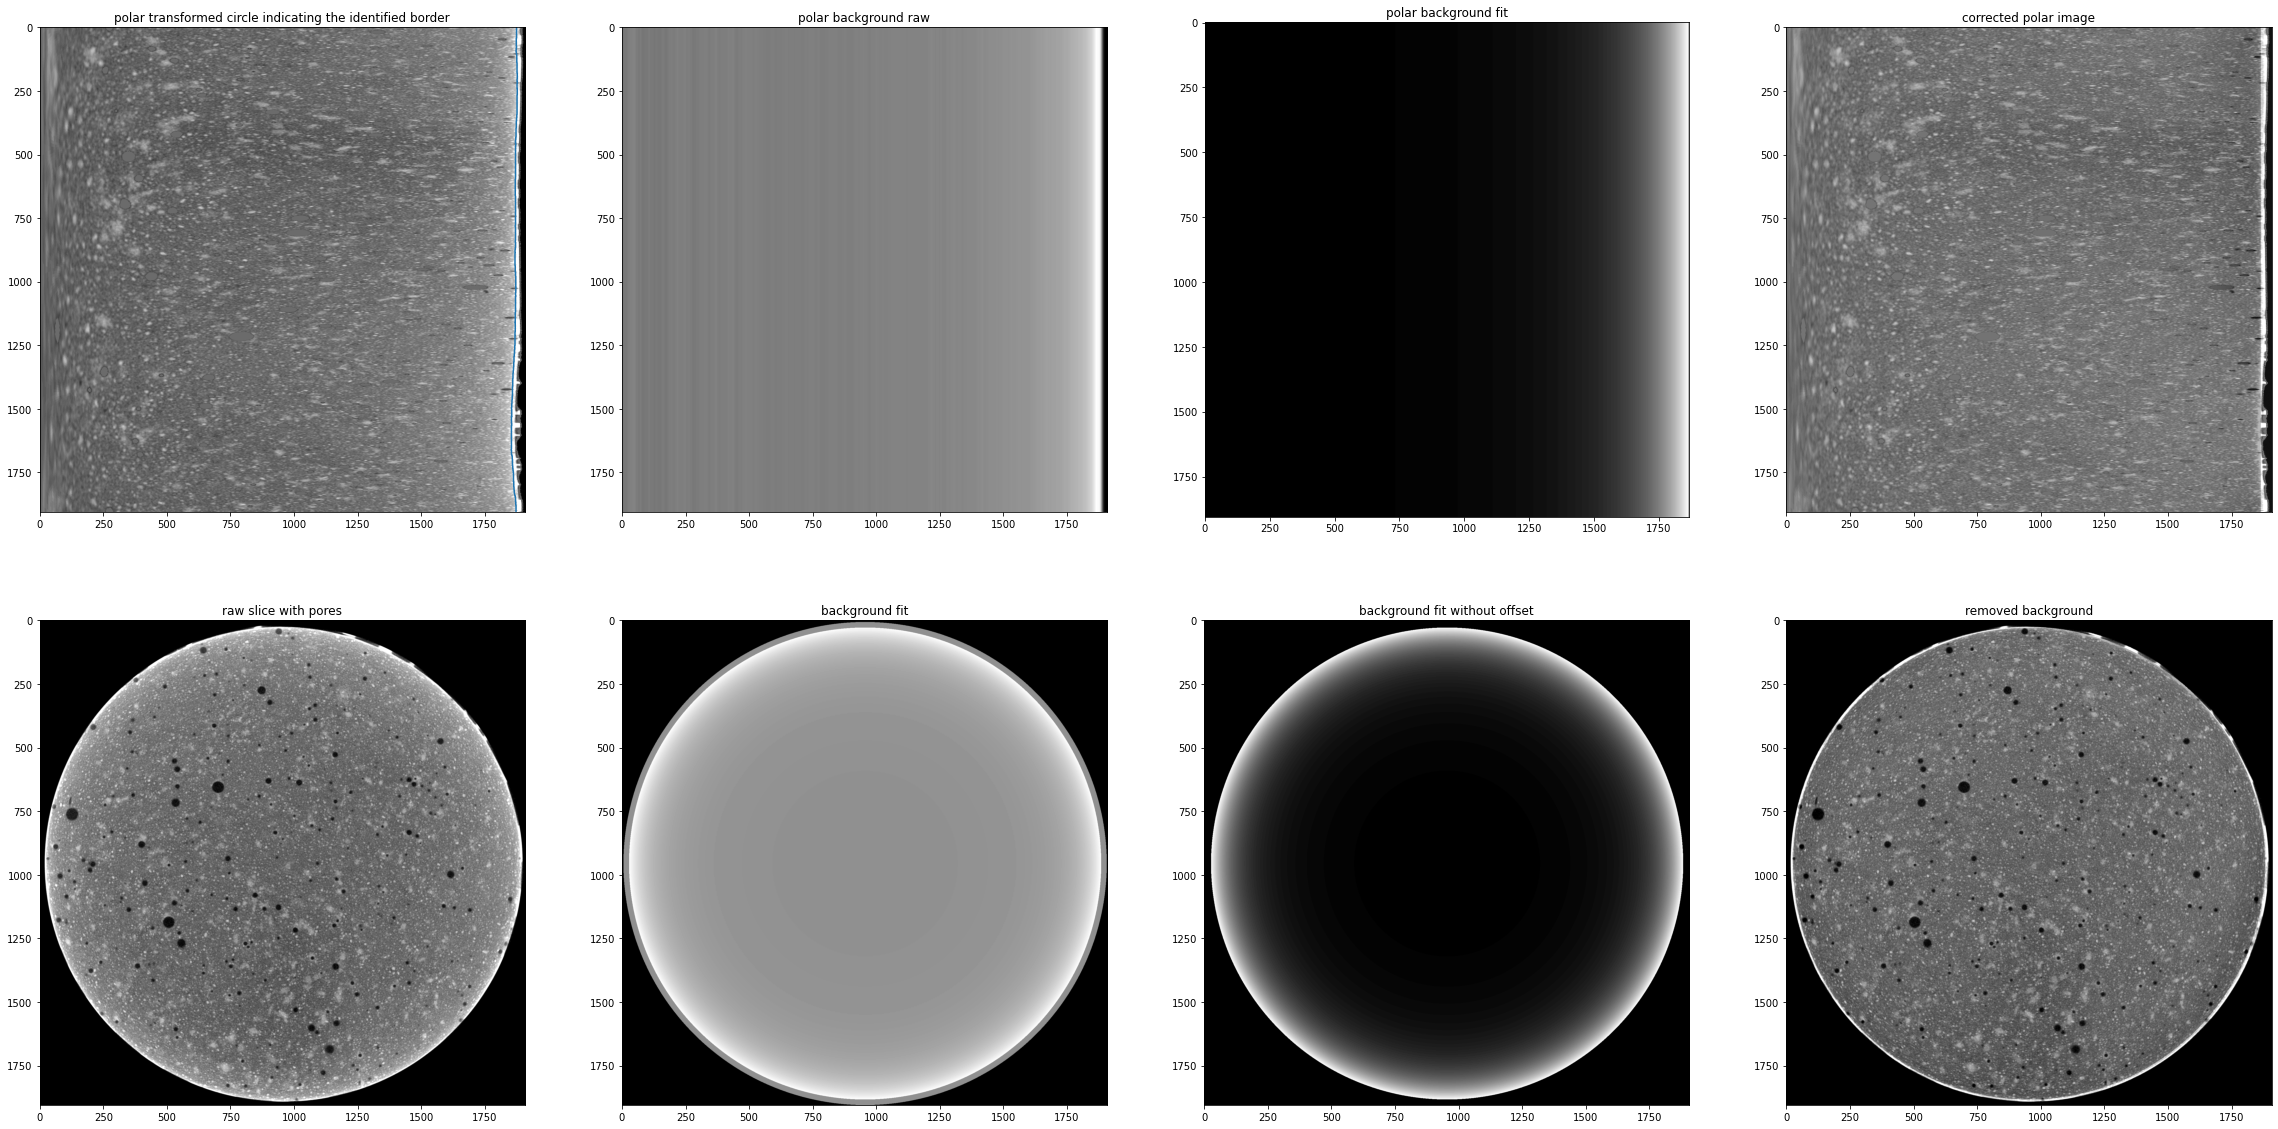

In [ ]:
#fixed_image = (polar_image-polar_background_fit)
#unpolar = cv2.linearPolar(fixed_image,(CT.center[0], CT.center[1]), CT.min_length, cv2.WARP_INVERSE_MAP)

fixed_image = (CT.circle_to_polar(slice)-polar_background_fit)
unpolar = cv2.linearPolar(fixed_image,(CT.center[0], CT.center[1]), CT.min_length, cv2.WARP_INVERSE_MAP).clip(min=0)

fig, ax = plt.subplots(2,4, figsize=(40,20))
ax[0,0].imshow( polar_image, cmap='gray' )
ax[0,0].plot( border_position,range(len(border_position)) )
ax[0,0].set_title( "polar transformed circle indicating the identified border" )
ax[0,1].imshow( polar_background, cmap='gray' )
ax[0,1].set_title( "polar background raw" )
ax[0,2].imshow( polar_background_fit[:, 0:CT.border_position], cmap='gray' )
ax[0,2].set_title( "polar background fit" )
ax[0,3].imshow( polar_image-polar_background_fit, cmap='gray' )
ax[0,3].set_title( "corrected polar image" )
ax[1,0].imshow( slice, cmap='gray' )
ax[1,0].set_title( "raw slice with pores" )
ax[1,1].imshow( CT.polar_to_circle( polar_background_fit+background_offset ), cmap='gray' )
ax[1,1].set_title( "background fit" )
ax[1,2].imshow( CT.polar_to_circle( polar_background_fit ), cmap='gray' )
ax[1,2].set_title( "background fit without offset" )
ax[1,3].imshow( unpolar, cmap='gray' )
ax[1,3].set_title( "removed background" )
plt.show()

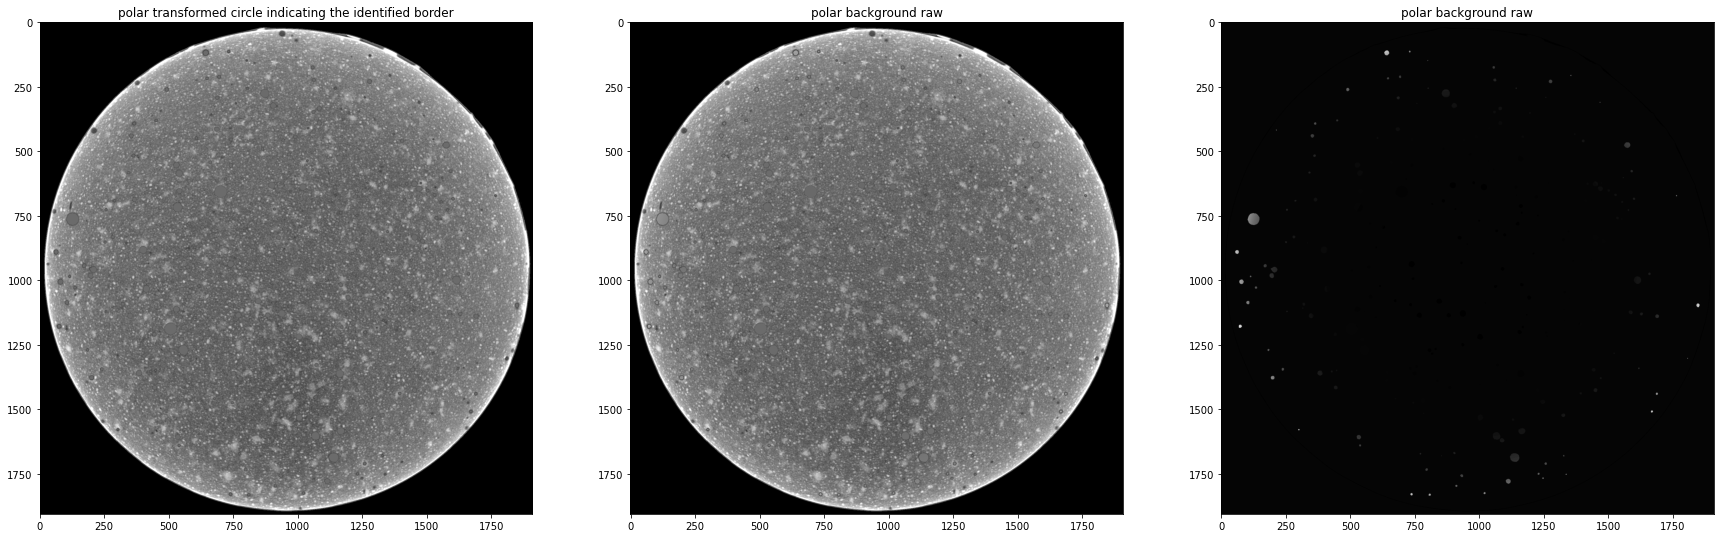

In [ ]:

removed_pores2 = CT.slice * np.logical_not(CT.inner_pores) + CT.inner_pores * (CT.polar_to_circle( polar_background_fit+background_offset ))

fig, ax = plt.subplots(1,3, figsize=(30,25))
ax[0].imshow( CT.removed_pores, cmap='gray' )
ax[0].set_title( "polar transformed circle indicating the identified border" )
ax[1].imshow( removed_pores2, cmap='gray' )
ax[1].set_title( "polar background raw" )
ax[2].imshow( removed_pores2-CT.removed_pores, cmap='gray' )
ax[2].set_title( "polar background raw" )
plt.show()

<ipython-input-13-a4eae5554881>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  inner_pores2 = (np.array(cv2.threshold( blur, 70, 255, cv2.THRESH_BINARY_INV ))[1] - CT.main_circle)/255


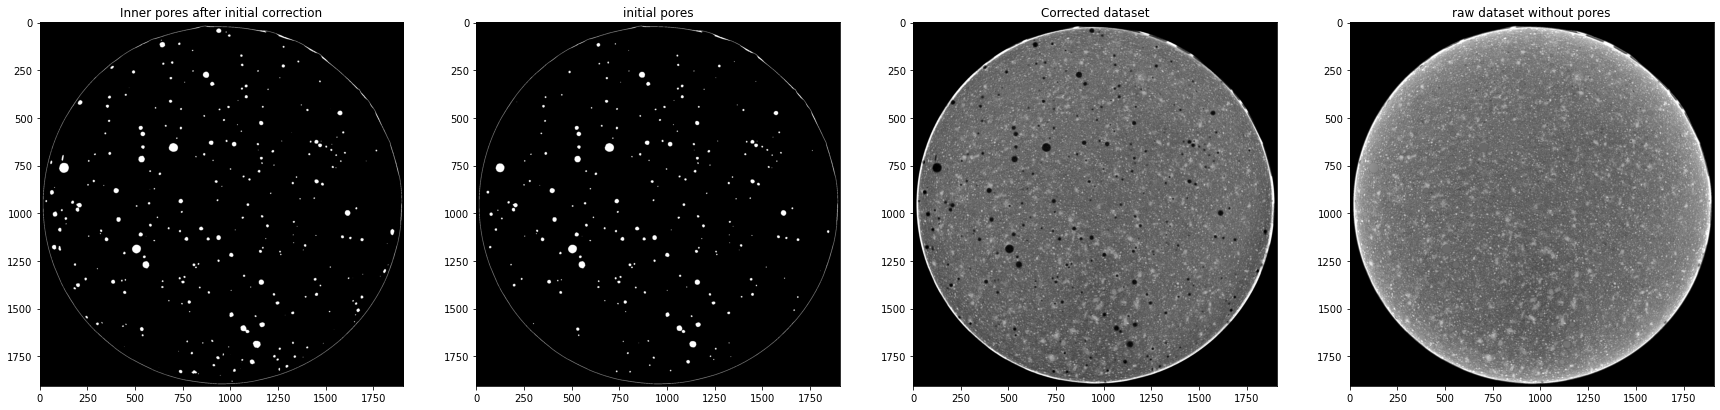

In [ ]:
blur = cv2.GaussianBlur( unpolar.astype(np.uint8), (11,11), 0)
inner_pores2 = (np.array(cv2.threshold( blur, 70, 255, cv2.THRESH_BINARY_INV ))[1] - CT.main_circle)/255
#(self.pore_thresh - self.main_circle)/255
removed_pores3 = (CT.slice * np.logical_not(inner_pores2) + inner_pores2 * (CT.polar_to_circle( polar_background_fit+background_offset ))).astype(np.uint8)

fig, ax = plt.subplots(1,4, figsize=(30,25))
ax[0].imshow( inner_pores2, cmap='gray' )
ax[0].set_title( "Inner pores after initial correction" )
ax[1].imshow( CT.inner_pores, cmap='gray' )
ax[1].set_title( "initial pores" )
ax[2].imshow( unpolar.astype(np.uint8), cmap='gray' )
ax[2].set_title( "Corrected dataset" )
ax[3].imshow( removed_pores3, cmap='gray' )
ax[3].set_title( "raw dataset without pores" )
plt.show()